In [1]:
import hopsworks

proj = hopsworks.login()
fs = proj.get_feature_store()

2025-08-22 12:11:43,515 INFO: Python Engine initialized.

Logged in to project, explore it here https://snurran.devnet.hops.works/p/120


In [2]:
fg =  fs.get_feature_group("wider_face_files", version=1)

In [3]:
df = fg.read()
df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.19s) 


file_path  \
0     /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
1     /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
2     /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3     /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
4     /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
...                                                 ...   
3076  /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
3077  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3078  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3079  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3080  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   

                file_timestamp  file_size_mb  num_bboxes  \
0    2025-08-21 08:06:56+00:00      0.115531           2   
1    2025-08-21 08:03:27+00:00      0.091335           7   
2    2025-08-21 08:02:25+00:00      0.090383          11   
3    2025-08-21 08:02:59+00:00      0.081689           2   
4    2025-08-21 08:03:26+00:00      0.087067          13   
...                        ...           ...         ...   
3076 2025-08-21 08:02:16+00:00      0.052416          14   
3077 2025-08-21 08:05:40+00:00      0.125594           1   
3078 2025-08-21 08:02:19+00:00      0.059752           3   
3079 2025-08-21 08:05:11+00:00      0.040192           2   
3080 2025-08-21 08:04:39+00:00      0.076458           1   

                                                 bboxes  label  \
0     [[546, 253, 250, 331, 0, 0, 0, 0, 0, 0], [427,...  train   
1     [[300, 290, 41, 64, 1, 0, 0, 0, 0, 0], [405, 2...  train   
2     [[408, 225, 23, 28, 1, 0, 0, 0, 0, 0], [385, 2...  train   
3     [[606, 42, 108, 160, 0, 0, 0, 0, 0, 0], [572, ...    val   
4     [[343, 231, 22, 28, 2, 0, 0, 0, 0, 0], [391, 2...  train   
...                                                 ...    ...   
3076  [[955, 77, 26, 31, 1, 0, 0, 0, 0, 0], [866, 72...    val   
3077           [[277, 173, 233, 318, 0, 0, 0, 0, 0, 0]]  train   
3078  [[106, 148, 58, 94, 0, 0, 0, 0, 0, 0], [208, 1...  train   
3079  [[648, 44, 82, 150, 0, 0, 1, 0, 0, 0], [240, 1...  train   
3080            [[254, 18, 292, 420, 0, 0, 0, 0, 0, 0]]  train   

                          ingested_at  
0    2025-08-21 09:59:36.537187+00:00  
1    2025-08-21 09:59:36.537187+00:00  
2    2025-08-21 09:59:36.537187+00:00  
3    2025-08-21 09:59:40.996966+00:00  
4    2025-08-21 09:59:36.537187+00:00  
...                               ...  
3076 2025-08-21 09:59:40.996966+00:00  
3077 2025-08-21 09:59:36.537187+00:00  
3078 2025-08-21 09:59:36.537187+00:00  
3079 2025-08-21 09:59:36.537187+00:00  
3080 2025-08-21 09:59:36.537187+00:00  

[3081 rows x 7 columns]

In [4]:
count = (df["num_bboxes"] < 2).sum()
count

988

2025-08-22 12:11:46,516 INFO: generated new fontManager
2025-08-22 12:11:46,633 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



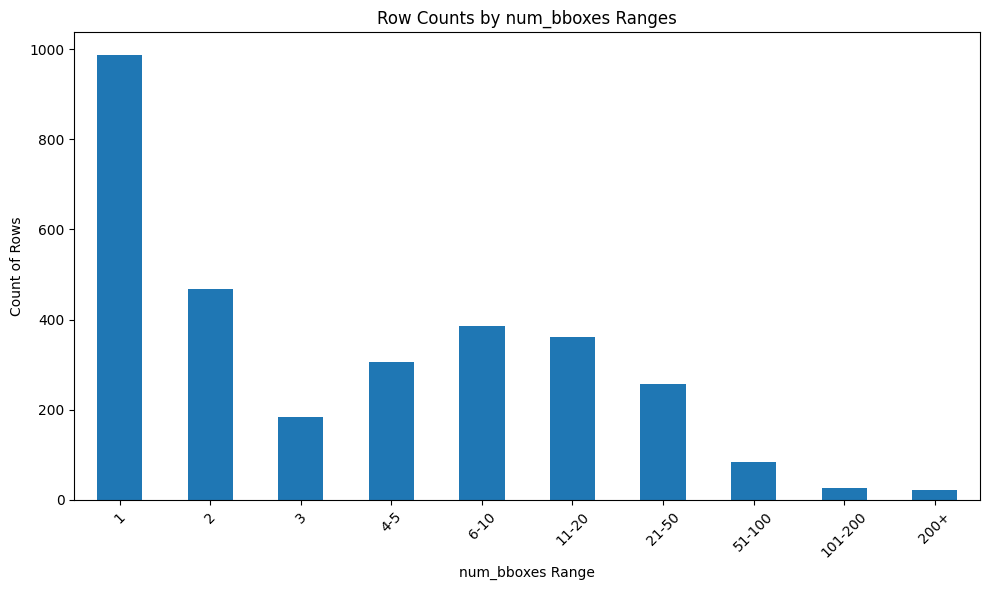

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Define bins and labels
bins = [0, 1, 2, 3, 5, 10, 20, 50, 100, 200, float("inf")]
labels = ["1", "2", "3", "4-5", "6-10", "11-20", "21-50", "51-100", "101-200", "200+"]

# Cut into bins
df["bbox_range"] = pd.cut(df["num_bboxes"], bins=bins, labels=labels, right=True)

# Count rows in each bin
counts = df["bbox_range"].value_counts().reindex(labels)

# Bar chart
plt.figure(figsize=(10,6))
counts.plot(kind="bar")

plt.title("Row Counts by num_bboxes Ranges")
plt.xlabel("num_bboxes Range")
plt.ylabel("Count of Rows")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
import argparse
import os
import shutil
import cv2
import ast

def copy_images(image_path, bboxes, output):
    annotations = {}
    filename = os.path.splitext(os.path.basename(image_path))[0]
    annotations[filename] = []
    shutil.copy2(image_path, output)
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    data_list = ast.literal_eval(bboxes)

    labels = []
    for data in data_list:    
        if data[0] > width or data[1] > height or data[2] > width or data[3] > height:
            continue
        cx = (data[0] + data[2] / 2) / width
        cy = (data[1] + data[3] / 2) / height
        w = data[2] / width
        h = data[3] / height
        label = f'0 {cx} {cy} {w} {h}'
        if label not in annotations[filename]:
            annotations[filename].append(label)

    with open(os.path.join(output, filename) + '.txt', 'w') as file:
        for row in annotations[filename]:
            file.write(row + '\n')    


train_images = "data/WIDER_train/images"
val_images = "data/WIDER_val/images"

output="data/widerface2"
train_labels="data/wider_face_split/wider_face_train_bbx_gt.txt"
val_labels="data/wider_face_split/wider_face_val_bbx_gt.txt"

train_output = os.path.join(output, 'train')
val_output = os.path.join(output, 'val')

if not os.path.exists(train_output):
    os.makedirs(train_output)
if not os.path.exists(val_output):
    os.makedirs(val_output)



In [ ]:
train_res = df.apply(lambda r: copy_images(r["file_path"], r["bboxes"], train_output), axis=1)
val_res  = val_df.apply(lambda r: copy_images(r["file_path"], r["bboxes"], val_output), axis=1)
# copy_images(val_images, val_labels, val_output)

In [ ]:
df.info()

In [8]:
fgSS =  fs.get_feature_group("image_embeddings", version=1)

dfS = fgSS.read()
dfS

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.35s) 


file_path  \
0     /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
1     /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
2     /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
3     /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
4     /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
...                                                 ...   
3076  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3077  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3078  /hopsfs/Jupyter/yolov8-face/data/WIDER_val/ima...   
3079  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   
3080  /hopsfs/Jupyter/yolov8-face/data/WIDER_train/i...   

                                              embedding  
0     [0.008230147883296013, 0.012926552444696426, -...  
1     [-0.008899090811610222, -0.0018667110707610846...  
2     [0.0029085339047014713, 0.007992787286639214, ...  
3     [-0.0012513964902609587, 0.02775312215089798, ...  
4     [-0.0039005109574645758, -0.028253495693206787...  
...                                                 ...  
3076  [-0.031009765341877937, 0.00562282046303153, -...  
3077  [-0.030828747898340225, -0.007190877106040716,...  
3078  [0.007744877599179745, 0.033385638147592545, 0...  
3079  [0.032876551151275635, 0.010465433821082115, 0...  
3080  [0.040801752358675, 0.015374615788459778, 0.00...  

[3081 rows x 2 columns]

In [9]:
from transformers import CLIPProcessor, CLIPModel
import torch
embedding_feature = fgSS.embedding_index.get_embedding("embedding")
model = embedding_feature.model
download_dir = model.download("/tmp")
model = CLIPModel.from_pretrained(download_dir)
processor = CLIPProcessor.from_pretrained(download_dir)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(f"\nDevice: {device}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Device: cuda


In [10]:
from PIL import Image

def get_image_embedding(image_path, processor, model):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            embedding = model.get_image_features(**inputs)

        # Normalize
        embedding = embedding / embedding.norm(p=2, dim=-1, keepdim=True)

        # Move back to CPU before converting to list
        return embedding.squeeze().cpu().tolist()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


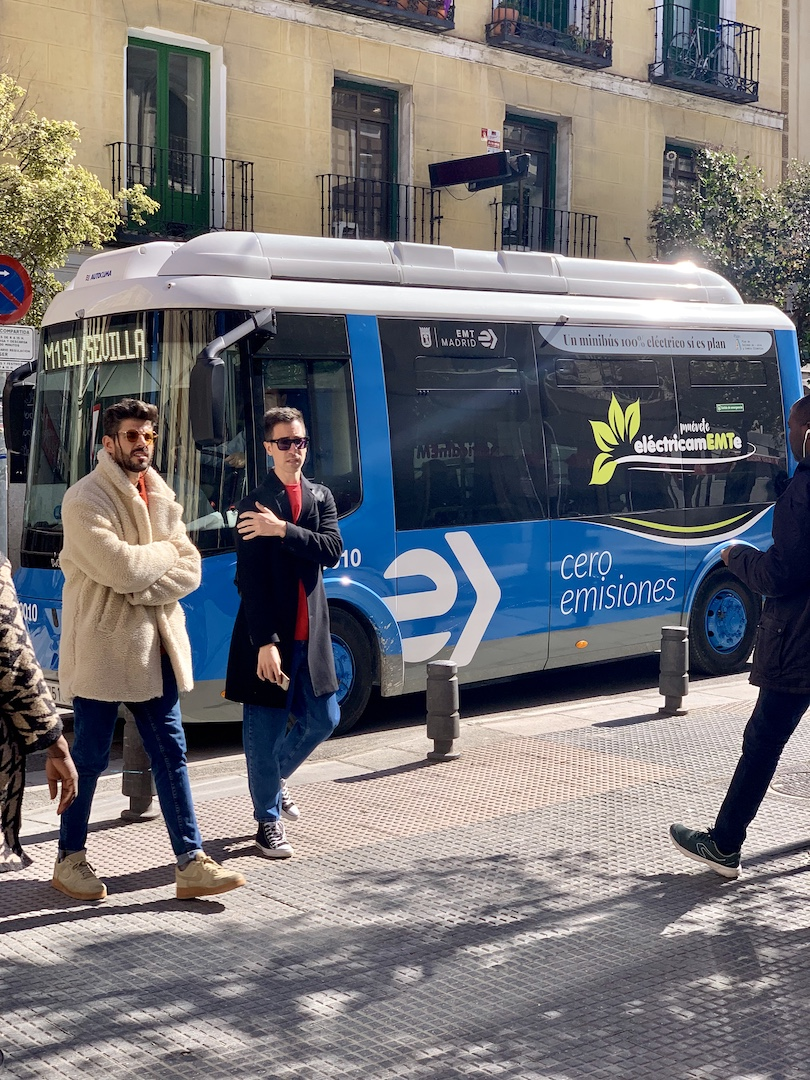

512

In [28]:
image="./data/images/bus.jpg"

img = Image.open(image)
display(img)

image_embedding = get_image_embedding(image, processor, model)
len(image_embedding)

In [33]:
!python predictsave.py --weights weights/yolov8n-face-lindevs.pt --source data/images/bus.jpg

Saved prediction to /hopsfs/Jupyter/yolov8-face/results/bus-faces-detected.png


In [12]:
print(fgSS.embedding_index)

{"indexName": "120__embedding_default_project_embedding_0", "features": [{"name": "embedding", "dimension": 512, "similarityFunctionType": "l2_norm", "model": {"modelRegistryId": 120, "modelName": "openaiclip_vit_base_patch32", "modelVersion": 1}}], "colPrefix": "1038_"}


In [13]:
from opensearchpy import OpenSearch

opensearch_api = proj.get_opensearch_api()
client = OpenSearch(**opensearch_api.get_default_py_config())

In [14]:
from opensearchpy import OpenSearch, exceptions

index_name = "120__embedding_default_project_embedding_0"

try:
    res = client.search(index=index_name, size=1)
    print("✅ Read access works")
    if "hits" in res:
        print("Got", res["hits"]["total"], "documents")
except exceptions.NotFoundError:
    print("❌ Index does not exist")
except exceptions.AuthorizationException:
    print("❌ You don’t have read permissions for this index")
except Exception as e:
    print("⚠️ Other error:", e)


2025-08-22 12:31:49,675 INFO: POST https://rest.elastic.service.consul:9200/120__embedding_default_project_embedding_0/_search?size=1 [status:200 request:0.015s]
2025-08-22 12:31:49,676 WARNING: DeprecationWarning: HTTPResponse.getheaders() is deprecated and will be removed in urllib3 v2.1.0. Instead access HTTPResponse.headers directly.

✅ Read access works
Got {'value': 3081, 'relation': 'eq'} documents


/hopsfs/Jupyter/yolov8-face/data/WIDER_val/images/14--Traffic/14_Traffic_Traffic_14_644.jpg


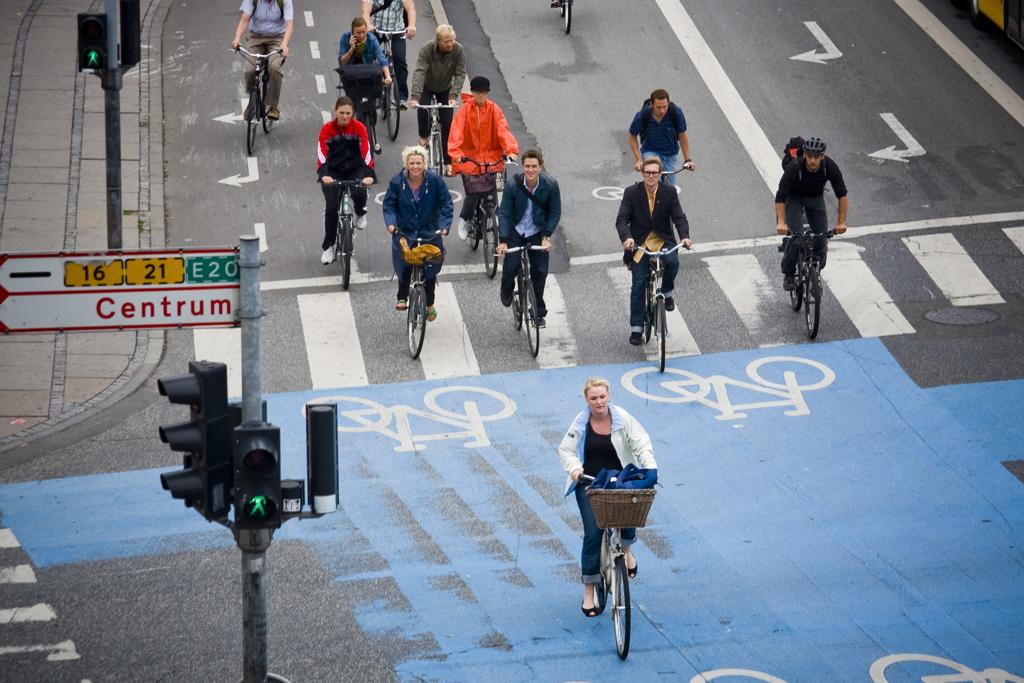

/hopsfs/Jupyter/yolov8-face/data/WIDER_val/images/15--Stock_Market/15_Stock_Market_Stock_Market_15_569.jpg


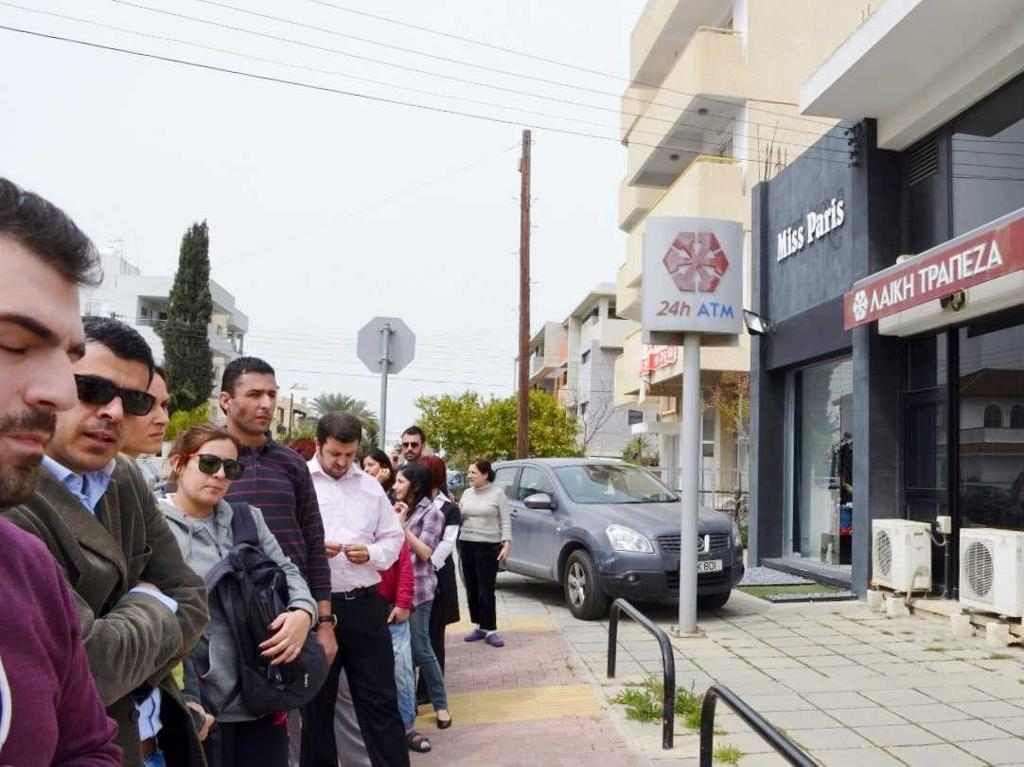

/hopsfs/Jupyter/yolov8-face/data/WIDER_train/images/12--Group/12_Group_Group_12_Group_Group_12_490.jpg


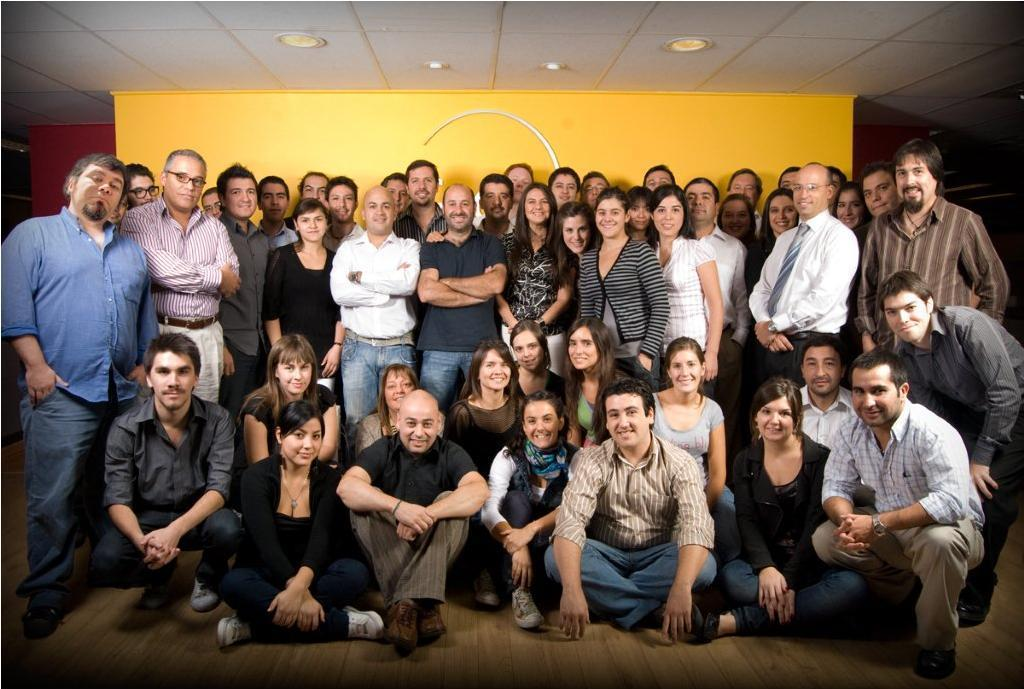

/hopsfs/Jupyter/yolov8-face/data/WIDER_train/images/14--Traffic/14_Traffic_Traffic_14_338.jpg


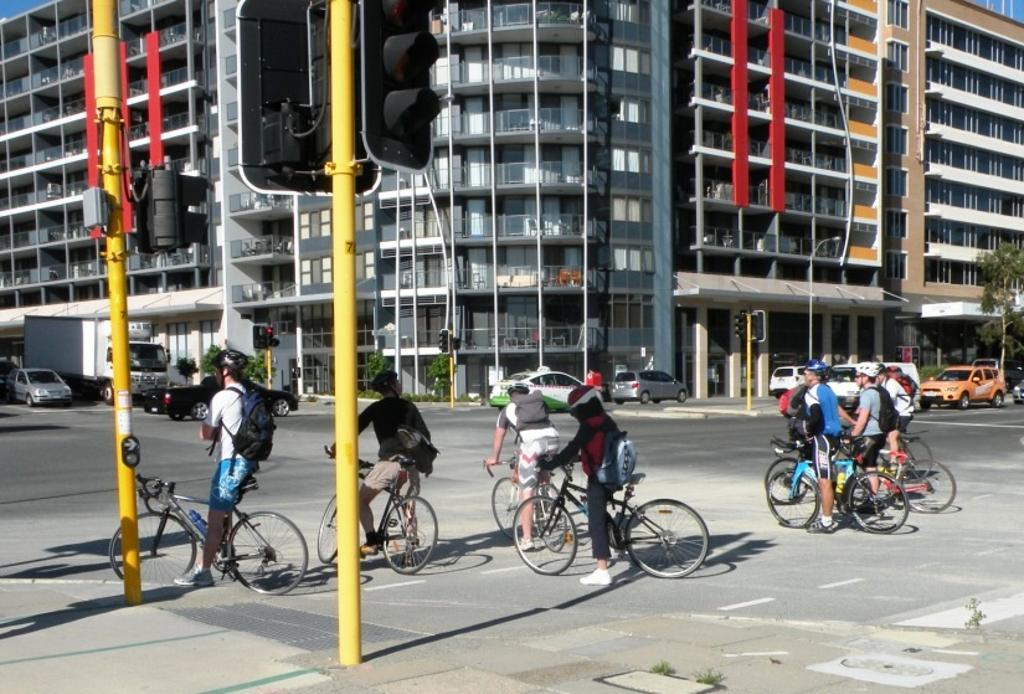

/hopsfs/Jupyter/yolov8-face/data/WIDER_train/images/14--Traffic/14_Traffic_Traffic_14_811.jpg


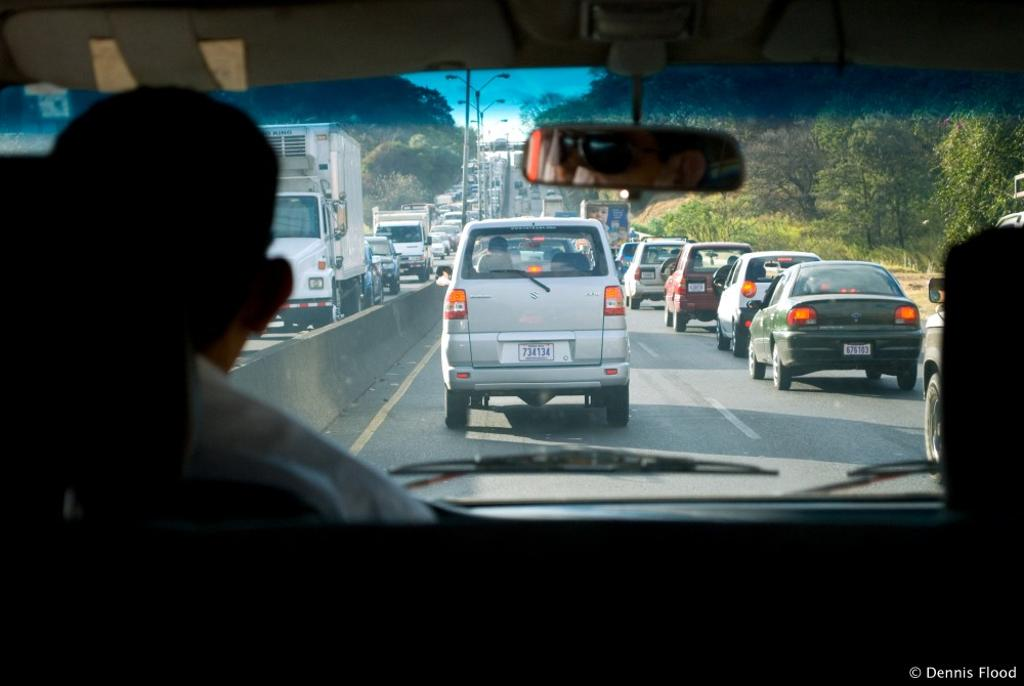

In [31]:
results = fgSS.find_neighbors(
    image_embedding, 
    k=5
)

for result in results:
    print(result[1][0])
    img = Image.open(result[1][0])
    display(img)

'/hopsfs/Jupyter/yolov8-face/data/WIDER_val/images/14--Traffic/14_Traffic_Traffic_14_644.jpg'